In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
import TSManager as ts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

from CorrScreen import CorrScreenPredictor
import TSManager as ts

In [3]:
#df = mgr.data
df = pd.read_pickle('train_prepared.pkl')
df.head()

,IC,VRP,BDI,SI,DP,PE,BM,CAPE,PCAPrice,BY,...,TERM,CAY,SIM,NOS,CPI,PCR,MA,OIL,SPX,RF
AsOfDate,,,,,,,,,,,,,,,,,,,,,
1990-06-08,NaN,0.737088,-0.152808,NaN,0.063979,7.524271,NaN,8.978524,3.616905,1.007418,...,0.50,-0.013576,0.715385,0.016941,0.046737,-1.622923,1.0,NaN,-0.012302,NaN
1990-06-11,NaN,-0.853208,-0.163823,NaN,0.063463,7.597792,NaN,9.051612,3.583706,1.009642,...,0.49,-0.013576,0.707692,0.016941,0.046737,-1.615366,1.0,NaN,0.008107,NaN
1990-06-12,NaN,-0.057387,-0.171766,NaN,0.062662,7.699009,NaN,9.167251,3.532720,1.009580,...,0.49,-0.013576,0.700000,0.016941,0.046737,-1.618868,1.0,NaN,0.012695,NaN
1990-06-13,NaN,1.332508,-0.180577,NaN,0.062894,7.674771,NaN,9.133460,3.547245,1.000056,...,0.47,-0.013576,0.692308,0.016941,0.046737,-1.625316,1.0,NaN,-0.003693,NaN
1990-06-14,NaN,1.204540,-0.189466,NaN,0.063241,7.636994,NaN,9.083400,3.569002,0.997689,...,0.46,-0.013576,0.684615,0.016941,0.046737,-1.620454,1.0,NaN,-0.005496,NaN


In [4]:
# constructing the target label
df['spx_tp130'] = df['SPX'].rolling(130).sum().shift(-129)
df = df.dropna(subset=['spx_tp130'])

In [5]:
# normalization pipeline
scaler = StandardScaler()
si = SimpleImputer(strategy='median')
pipe = make_pipeline(scaler, si)

In [6]:
#cols_to_pipe = [c for c in df.columns if c not in ['SPX','RF','spx_tp130']]
#df[cols_to_pipe] = pipe.fit_transform(df[cols_to_pipe])

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


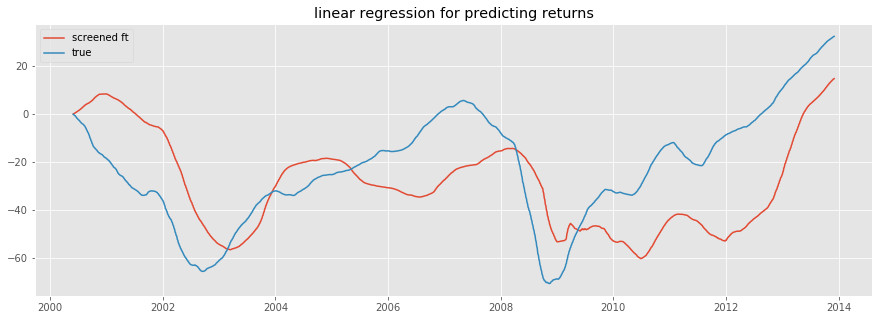

In [7]:
# test predictions

nbp = 170 # number of periods to be used
CSP = CorrScreenPredictor(df)
CSP.plot_predict(nbp)

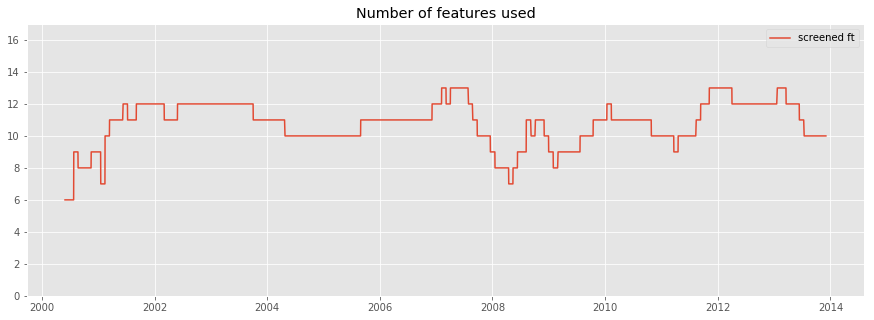

In [8]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

In [9]:
import handlers

class TradingBot:
    
    # index:             daily positions in SPX
    # update frequency:  positions are adjusted each time the return forecast change exceeds 10%
    # size:              eight times expected returns
    # caps:              strategy caped at 150% long / 50% short

    def __init__(self,data,threshold=0.1):
        self.threshold = threshold
        self.data = data
        rf = data['RF'][2520:].dropna().tolist()
        rf = filter(lambda s: s != '.', rf)
        self.rf = [float(s) for s in rf]
        #self.rf = [float(s)-30*0.01 for s in rf]
        
        
    def _rf(self,nb_periods):
        #
        # used to compute equity risk premium (predicted_return - 90-day Treasury Bill)
        #
        return self.rf[:20*nb_periods]
    
    def CS_pos(self,nb_periods):
        
        #
        # computes positions for correlation screening
        #
        
        rf = self._rf(nb_periods)

        CSP = CorrScreenPredictor(self.data,self.threshold)
        __p,ytrue,sft = CSP.predict(nb_periods)
        
        _p = np.exp(__p)
        
        p = [_p[i]-rf[i] for i in range(len(_p))]
        
        #plt.hist(_p,bins=50)
        #plt.title('returns distribution')
        #plt.plot(self.data.index[2520:(2520+nb_periods*20)],_p)
        #plt.show()
        
        #plt.hist(p,bins=50)
        #plt.title('premium distribution')
        #plt.plot(self.data.index[2520:(2520+nb_periods*20)],p)
        #plt.show()
        
        
        pos = [8*p[0]]
        last_return_forecast = p[0]
        for k in range(1,len(p)):
            return_forecast = p[k]
            chg = return_forecast/last_return_forecast
            if (chg>=1.1) or (chg<=0.9):
                # change of 10% 
                last_return_forecast = return_forecast
            # take position
            pos.append(8*last_return_forecast)
            
        # cap positions
        for i in range(len(pos)):
            if pos[i]>1.5:
                pos[i]=1.5
            elif pos[i]<-0.5:
                pos[i]=-0.5
                
        return pos
    
    def plot_wealth_CS(self,nb_periods):
        
        # compute positions
        CS_pos = self.CS_pos(nb_periods)
        
        # timeline
        timeline = self.data.index[2520:(2520+nb_periods*20)]
        
        # spx buy and hold
        spx_buy_hold = np.exp(self.data['SPX'][2520:(2520+nbp*20)].cumsum())
        
        # strategy
        strat_rt = pd.DataFrame([1 + (CS_pos[i] * (np.exp(self.data['SPX'][2520:(2520+nbp*20)][i]) - 1)) for i in range(len(CS_pos))]).cumprod()
        
        # plot
        plt.figure(figsize=(15,5))
        plt.plot(timeline,strat_rt,label='Correlation Screening')
        plt.plot(timeline,spx_buy_hold,label='SPX buy and hold')
        plt.title('Comparison between strategy and SPX')
        plt.legend()
        plt.show()
    
            
        
        
        
    
    

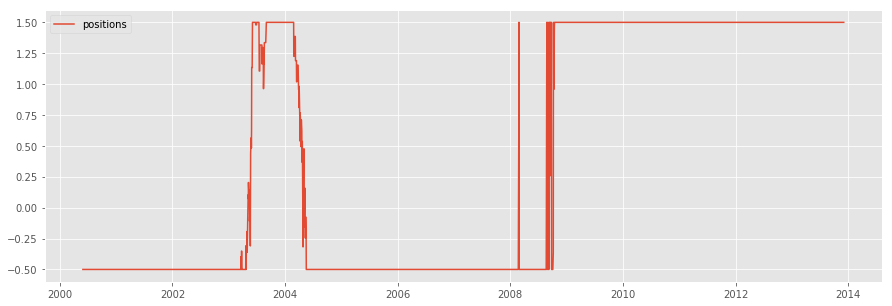

In [10]:
tb = TradingBot(df)

pos = tb.CS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

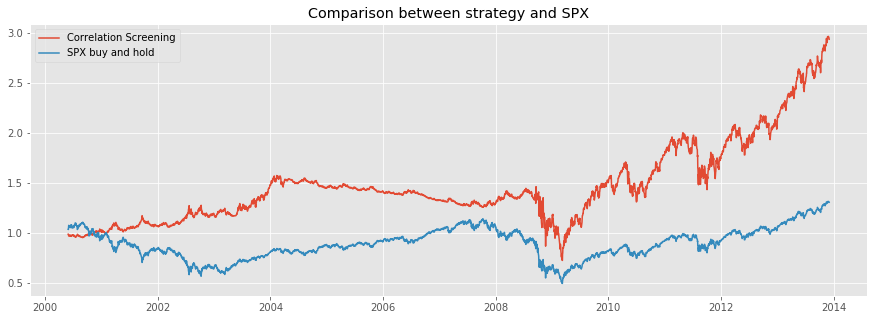

In [11]:
tb.plot_wealth_CS(nbp)